<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Contexte" data-toc-modified-id="Contexte-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Contexte</a></span></li><li><span><a href="#Importation-des-librairies" data-toc-modified-id="Importation-des-librairies-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Importation des librairies</a></span></li><li><span><a href="#Importation-de-la-base-de-données" data-toc-modified-id="Importation-de-la-base-de-données-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Importation de la base de données</a></span></li><li><span><a href="#Analyse" data-toc-modified-id="Analyse-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Analyse</a></span><ul class="toc-item"><li><span><a href="#Le-nombre-de-mots" data-toc-modified-id="Le-nombre-de-mots-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Le nombre de mots</a></span></li><li><span><a href="#Les-étiquettes" data-toc-modified-id="Les-étiquettes-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Les étiquettes</a></span><ul class="toc-item"><li><span><a href="#Les-intentions" data-toc-modified-id="Les-intentions-4.2.1"><span class="toc-item-num">4.2.1&nbsp;&nbsp;</span>Les intentions</a></span></li><li><span><a href="#Nos-entités" data-toc-modified-id="Nos-entités-4.2.2"><span class="toc-item-num">4.2.2&nbsp;&nbsp;</span>Nos entités</a></span></li></ul></li></ul></li><li><span><a href="#Préparation-des-données-pour-LUIS" data-toc-modified-id="Préparation-des-données-pour-LUIS-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Préparation des données pour LUIS</a></span><ul class="toc-item"><li><span><a href="#Préparation-des-données" data-toc-modified-id="Préparation-des-données-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Préparation des données</a></span><ul class="toc-item"><li><span><a href="#Exemple" data-toc-modified-id="Exemple-5.1.1"><span class="toc-item-num">5.1.1&nbsp;&nbsp;</span>Exemple</a></span></li><li><span><a href="#Préparation-de-nos-données" data-toc-modified-id="Préparation-de-nos-données-5.1.2"><span class="toc-item-num">5.1.2&nbsp;&nbsp;</span>Préparation de nos données</a></span></li></ul></li></ul></li><li><span><a href="#Fonctions-utiles" data-toc-modified-id="Fonctions-utiles-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Fonctions utiles</a></span></li></ul></div>

# Contexte

La création d’une application avec Conversational Language Understanding se compose de deux tâches principales :

- définir les entités, les intentions et les énoncés avec lesquels entraîner le modèle de langage. Il s'agit de la création du modèle.

- publier le modèle afin que les applications clientes puissent l’utiliser pour la prédiction des intentions et des entités en fonction des entrées utilisateur.

N'oublions pas que pour les fonctionnalités de la V1 du chatbot doivent permettre l'identification dans la demande de l’utilisateur les cinq éléments suivants uniquement :

- Ville de départ
- Ville de destination
- Date aller souhaitée du vol
- Date retour souhaitée du vol
- Budget maximum pour le prix total des billets.

# Importation des librairies

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from collections import defaultdict

In [3]:
import os
import urllib, zipfile
import json

from my_luis import *  # Charge les fonctions utiles au projet LUIS

# Importation de la base de données

Le jeu de données est fourni par Microsoft. Il consiste en différents dialogues entre deux personnes (user et wizard).
Il y a en tout 1369 dialogues.

L'user demande à wizard de réserver un trajet ou un séjour. Il donne des informations comme :
- le lieu de départ
- le lieu de destination
- l'heure de départ
- l'heure d'arrivée
- le budget.

Il s'agit des entités, elles sont déjà étiquettées dans notre jeu de données.

Le wizard va répondre à ces demandes grâce aux informations fournies par le user.
Suivant la satisfaction que lui aura donné la réponse, l'user laissera une note au wizard.

Source du jeu de données : 
https://www.microsoft.com/en-us/research/project/frames-dataset/download/

Afin d'avoir la base de données la plus récente, nous allons charger directement la base de données depuis l'url.

In [5]:
url_oc = "https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/AI+Engineer/Project+10%C2%A0-+D%C3%A9veloppez+un+chatbot+pour+r%C3%A9server+des+vacances/frames.zip"
nom_fichier = "frames.json"

La bibliothèque urllib et particulièrement la fonction request : https://docs.python.org/3/library/urllib.request.html

La bibliothèque zipfile : https://docs.python.org/3/library/zipfile.html

In [7]:
""" Cette fonction permet de télécharger les données depuis une url et de les enregistrer dans un fichier.
Entrées :
url : l'url qui contient les données
nom : le nom du fichier qui contiendra les données
dossier : le dossier qui contiendra le fichier de données"""
# Chargement et enregistrement des données
load_donnees_url(url_oc, nom_fichier, chemin_fichier)

Le téléchargement de vos données a commencé.
Le téléchargement des données est terminé.


Le fichier téléchargé n'est constitué que d'un seul json. Regardons de combien de dialogues (ou frames) il est composé.

In [8]:
with open(chemin_fichier + nom_fichier) as file:
    frames = json.load(file)

print(f"Le jeu de donnée contient {len(frames)} dialogues.")

Le jeu de donnée contient 1369 dialogues.


In [9]:
frames[0]

{'user_id': 'U22HTHYNP',
 'turns': [{'text': "I'd like to book a trip to Atlantis from Caprica on Saturday, August 13, 2016 for 8 adults. I have a tight budget of 1700.",
   'labels': {'acts': [{'args': [{'val': 'book', 'key': 'intent'}],
      'name': 'inform'},
     {'args': [{'val': 'Atlantis', 'key': 'dst_city'},
       {'val': 'Caprica', 'key': 'or_city'},
       {'val': 'Saturday, August 13, 2016', 'key': 'str_date'},
       {'val': '8', 'key': 'n_adults'},
       {'val': '1700', 'key': 'budget'}],
      'name': 'inform'}],
    'acts_without_refs': [{'args': [{'val': 'book', 'key': 'intent'}],
      'name': 'inform'},
     {'args': [{'val': 'Atlantis', 'key': 'dst_city'},
       {'val': 'Caprica', 'key': 'or_city'},
       {'val': 'Saturday, August 13, 2016', 'key': 'str_date'},
       {'val': '8', 'key': 'n_adults'},
       {'val': '1700', 'key': 'budget'}],
      'name': 'inform'}],
    'active_frame': 1,
    'frames': [{'info': {'intent': [{'val': 'book', 'negated': False}],
 

Nous voyons qu'un dialogue est composé de différentes variables. Ces différentes variables sont détaillées dans la documentation du jeu de données de Microsoft.

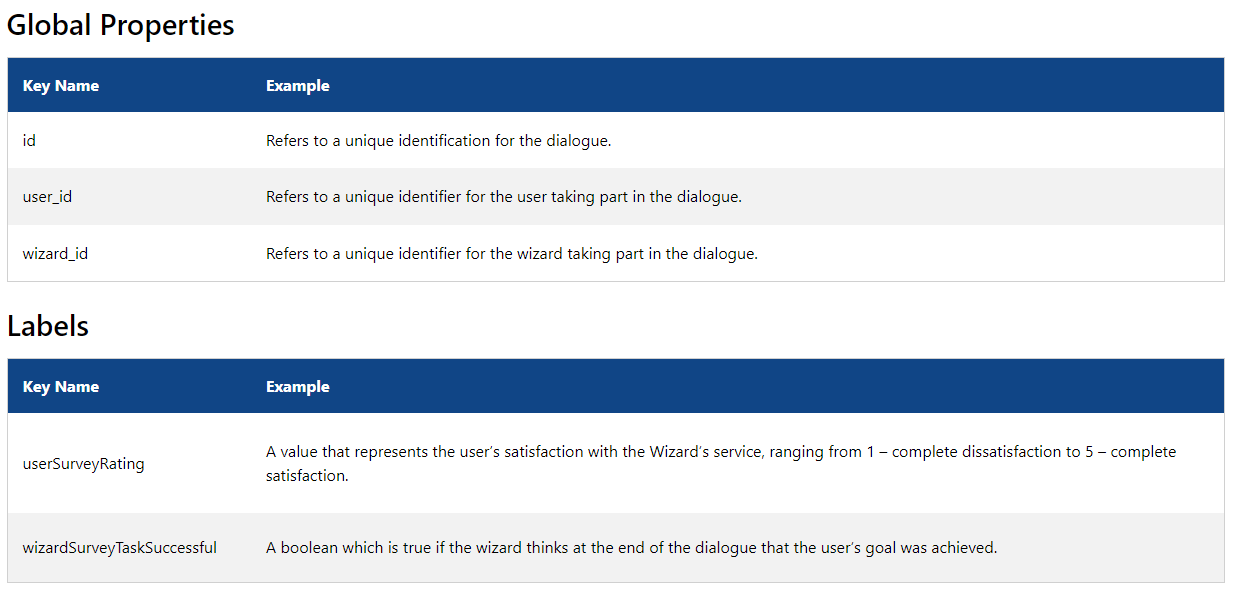

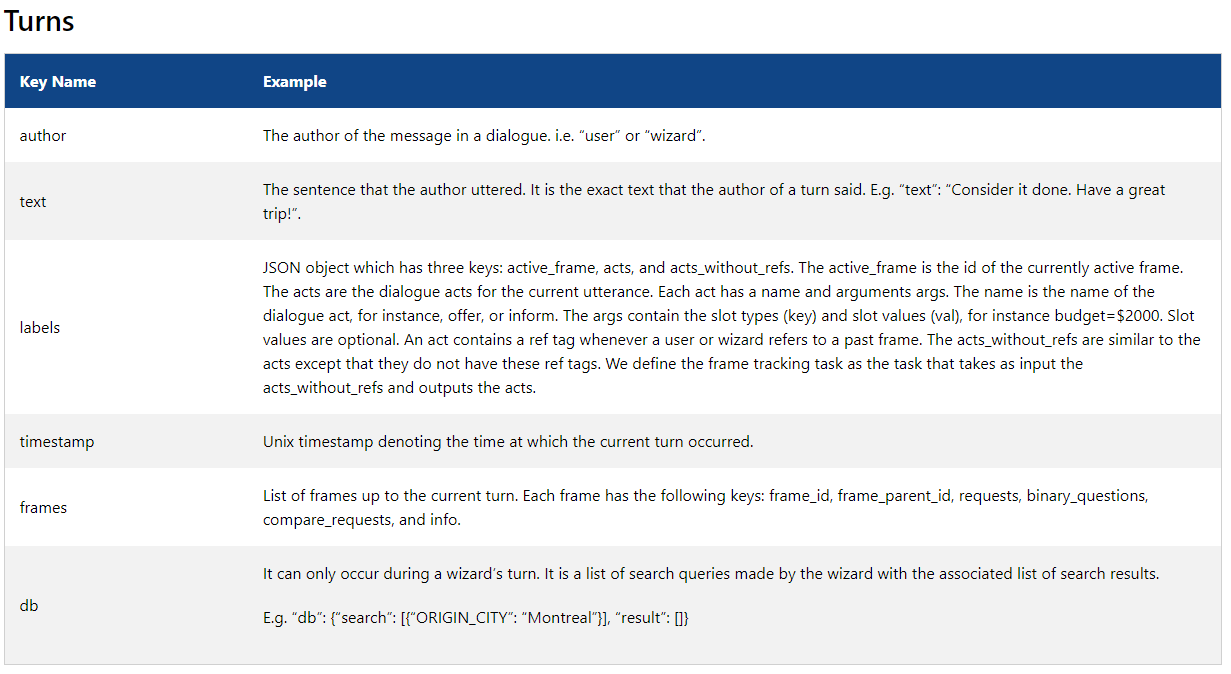

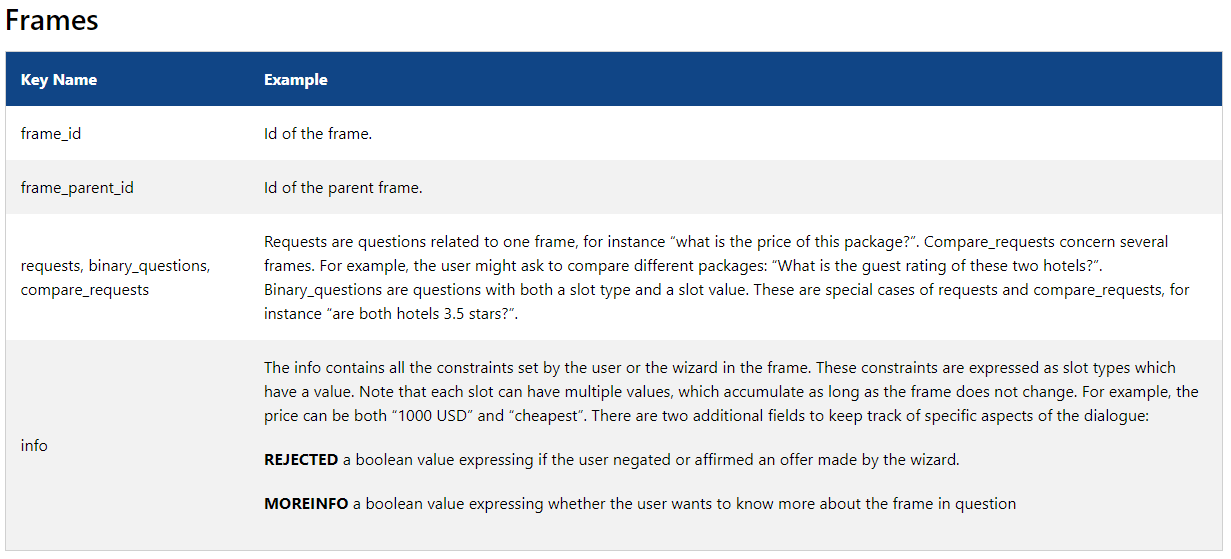

Les textes avec les étiquettages se trouvent dans la variable "turns". Nous pouvons regarder uniquement les textes échangés ainsi que l'auteur du texte.

In [10]:
for t in frames[0]["turns"]:
    print(t.get("author", ""), ":",
          t.get("text",
                ""))  # Il s'agit d'un dictionnaire alors nous utilisons "get"

user : I'd like to book a trip to Atlantis from Caprica on Saturday, August 13, 2016 for 8 adults. I have a tight budget of 1700.
wizard : Hi...I checked a few options for you, and unfortunately, we do not currently have any trips that meet this criteria.  Would you like to book an alternate travel option?
user : Yes, how about going to Neverland from Caprica on August 13, 2016 for 5 adults. For this trip, my budget would be 1900.
wizard : I checked the availability for this date and there were no trips available.  Would you like to select some alternate dates?
user : I have no flexibility for dates... but I can leave from Atlantis rather than Caprica. How about that?
wizard : I checked the availability for that date and there were no trips available.  Would you like to select some alternate dates?
user : I suppose I'll speak with my husband to see if we can choose other dates, and then I'll come back to you.Thanks for your help


# Analyse

Dans cette partie nous allons réaliser quelques analyses des dialogues de notre jeu de données.

## Le nombre de mots

Dans un premier temps regardons les nombres de mots par texte. Pour cette analyse, ce qui nous intéresse c'est qui de l'user ou du wizard a écrit le texte et le nombre de mots.

In [11]:
# Création d'une base de données

data = []

# Extraction des données d'intérêt
for i, f in enumerate(frames):  # Pour chaque dialogue ( n = 1369)
    for t in f["turns"]:
        data.append({
            "numero_dialogue":
            i,  # Ce qui nous intéresse : l'indicatif du dialogue
            "interlocuteur": t["author"],  # l'auteur
            "texte": t["text"]  # Et le texte
        })

# Création de la base de données
df = pd.DataFrame(data)

# On ajoute le nombre de mots par texte
df["nb_mots"] = df["texte"].apply(lambda x: len(x.split()))

df.head()

,numero_dialogue,interlocuteur,texte,nb_mots
0,0,user,I'd like to book a trip to Atlantis from Capri...,25
1,0,wizard,"Hi...I checked a few options for you, and unfo...",29
2,0,user,"Yes, how about going to Neverland from Caprica...",23
3,0,wizard,I checked the availability for this date and t...,21
4,0,user,I have no flexibility for dates... but I can l...,18


In [12]:
df.shape

(19986, 4)

In [13]:
df["nb_mots"].describe()

count    19986.000000
mean        12.602172
std         10.892189
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max        112.000000
Name: nb_mots, dtype: float64

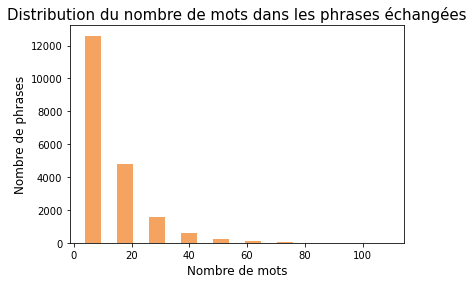

In [14]:
plt.hist(df["nb_mots"], color="sandybrown", rwidth=0.5)
plt.title("Distribution du nombre de mots dans les phrases échangées",
          fontsize=15)
plt.xlabel("Nombre de mots", fontsize=12)
plt.ylabel("Nombre de phrases", fontsize=12)
plt.show()

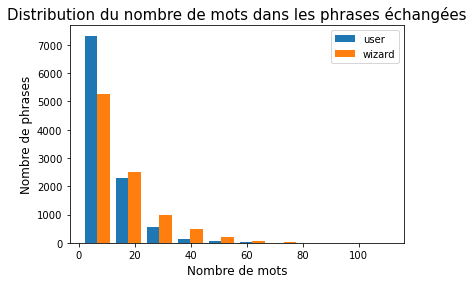

In [15]:
plt.hist([
    df["nb_mots"][df["interlocuteur"] == "user"],
    df["nb_mots"][df["interlocuteur"] == "wizard"]
],
         label=['user', 'wizard'])
plt.legend(loc='upper right')
plt.title("Distribution du nombre de mots dans les phrases échangées",
          fontsize=15)
plt.xlabel("Nombre de mots", fontsize=12)
plt.ylabel("Nombre de phrases", fontsize=12)
plt.show()

Nous voyons que dans l'ensemble, les users ont tendance à faire des phrases plus longues que les wizards.

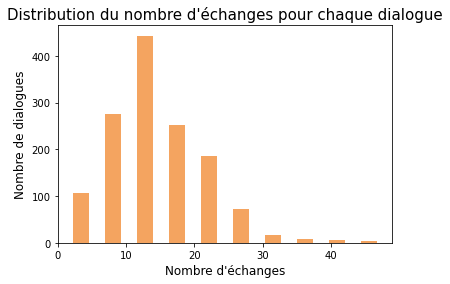

In [16]:
plt.hist(df.groupby("numero_dialogue").agg({"texte": "count"}),
         color="sandybrown",
         rwidth=0.5)
plt.title("Distribution du nombre d'échanges pour chaque dialogue",
          fontsize=15)
plt.xlabel("Nombre d'échanges", fontsize=12)
plt.ylabel("Nombre de dialogues", fontsize=12)
plt.show()

Nous voyons que le nombre d'échanges entre le wizard et l'user tourne autour de 10/15 par dialogue.

## Les étiquettes

Lorsque nous avons visualisé les dialogues, nous avons remarqué qu'au sein des "turns" il y avait des variables étiquettées.

<font color='lightblue'>
   
**labels** : 
JSON object which has three keys: active_frame, acts, and acts_without_refs. The active_frame is the id of the currently active frame. The acts are the dialogue acts for the current utterance. Each act has a name and arguments args. The name is the name of the dialogue act, for instance, offer, or inform. The args contain the slot types (key) and slot values (val), for instance budget=$2000. Slot values are optional. An act contains a ref tag whenever a user or wizard refers to a past frame. The acts_without_refs are similar to the acts except that they do not have these ref tags. We define the frame tracking task as the task that takes as input the acts_without_refs and outputs the acts.

</font>

Nous allons regarder les différentes "keys" des labels.

In [17]:
print(json.dumps(frames[0]["turns"][0]["labels"]["active_frame"], indent=2))

1


In [18]:
print(json.dumps(frames[0]["turns"][0]["labels"]["acts"], indent=2))

[
  {
    "args": [
      {
        "val": "book",
        "key": "intent"
      }
    ],
    "name": "inform"
  },
  {
    "args": [
      {
        "val": "Atlantis",
        "key": "dst_city"
      },
      {
        "val": "Caprica",
        "key": "or_city"
      },
      {
        "val": "Saturday, August 13, 2016",
        "key": "str_date"
      },
      {
        "val": "8",
        "key": "n_adults"
      },
      {
        "val": "1700",
        "key": "budget"
      }
    ],
    "name": "inform"
  }
]


In [19]:
print(
    json.dumps(frames[0]["turns"][0]["labels"]["acts_without_refs"], indent=2))

[
  {
    "args": [
      {
        "val": "book",
        "key": "intent"
      }
    ],
    "name": "inform"
  },
  {
    "args": [
      {
        "val": "Atlantis",
        "key": "dst_city"
      },
      {
        "val": "Caprica",
        "key": "or_city"
      },
      {
        "val": "Saturday, August 13, 2016",
        "key": "str_date"
      },
      {
        "val": "8",
        "key": "n_adults"
      },
      {
        "val": "1700",
        "key": "budget"
      }
    ],
    "name": "inform"
  }
]


Nous voyons qu'il y a plusieurs données qui vont nous aider à créer notre modèle. 
Nous pouvons à partir de ces dialogues créer :
- les intentions, avec pour chaque intention, une liste d'énoncés qui fournissent des exemples
- les entités.

Par exemple, pour ce dialogue, nous avons l'intention "book" (réserver) et les entités : dst_city (ville de destination), or_city (ville de départ), str_date, n_adults, budget.

In [20]:
etiquettes = defaultdict(list)
for f in frames:
    for t in f["turns"]:

        if t["author"] != "user":  # Nous ne prenons pas en compte les dialogues venant du wizard
            continue

        for args in t["labels"]["acts_without_refs"]:

            # On cherche chaque label de la liste
            for label in args["args"]:
                try:
                    # On ajoute la valeur pour chaque label
                    etiquettes[label["key"]].append(label.get("val", ""))
                except:
                    print(label)

Pour l'utilisation de defaultdict : https://www.geeksforgeeks.org/defaultdict-in-python/

In [21]:
etiquettes

defaultdict(list,
            {'intent': ['book',
              'book',
              'book',
              'book',
              'book',
              'book',
              'book',
              'book',
              'book',
              'book',
              'book',
              'book',
              'book',
              'book',
              'book',
              'book',
              'book',
              'book',
              'book',
              'book',
              'book',
              'book',
              'book',
              'book',
              'book',
              'book',
              'book',
              'book',
              'book',
              'book',
              'book',
              'book',
              'book',
              'book',
              'book',
              'book',
              'book',
              'book',
              'book',
              'book',
              'book',
              'book',
              'book',
              'book',
    

Nous pouvons voir qu'il y a quelques valeurs "None" pourtant indexée dans les dictionnaires des étiquettes. Il y a aussi des valeurs abérrantes comme "-1" pour des villes de départ ou d'arrivée.

Nous allons créer une base de données pour pouvoir mieux explorer ce dictionnaire.

In [22]:
# On crée un dataframe
labels = pd.Series(etiquettes).to_frame("liste_des_valeurs")
labels.head(5)

,liste_des_valeurs
intent,"[book, book, book, book, book, book, book, boo..."
dst_city,"[Atlantis, Neverland, Mos Eisley, Neverland, M..."
or_city,"[Caprica, Caprica, Atlantis, Caprica, Gotham C..."
str_date,"[Saturday, August 13, 2016, August 13, 2016, -..."
n_adults,"[8, 5, 5, 2, 2, 3, with 14 adults, 1, 12, Just..."


Nous allons ajouter une colonne qui compte le nombre de valeurs, une colonne qui répertorie les valeurs uniques et un colonne qui compte le nombre de valeurs uniques.

In [23]:
# Ajout de la colonne avec le nombre de valeurs pour chaque étiquette
labels["nb_valeurs"] = labels["liste_des_valeurs"].apply(len)

# Ajout de la colonne avec les valeurs uniques de chaque label
labels["valeurs_uniques"] = labels["liste_des_valeurs"].apply(set)

# Ajout de la colonne avec le nombre de valeurs uniques pour chaque label
labels["nb_valeurs_uniques"] = labels["valeurs_uniques"].apply(len)

# Tri des lignes par le plus grand nombre de valeurs
labels = labels.sort_values("nb_valeurs", ascending=False)

labels.head(5)

,liste_des_valeurs,nb_valeurs,valeurs_uniques,nb_valeurs_uniques
dst_city,"[Atlantis, Neverland, Mos Eisley, Neverland, M...",3541,"{Rome, Korea, Minneapolis, Jersusalem, nagoya,...",364
intent,"[book, book, book, book, book, book, book, boo...",2006,{book},1
or_city,"[Caprica, Caprica, Atlantis, Caprica, Gotham C...",1962,"{Rome, JErusalem, Minneapolis, nagoya, Cairo, ...",333
str_date,"[Saturday, August 13, 2016, August 13, 2016, -...",1544,"{9/1, sept 12, after Sept 6, sooner, 12 of sep...",447
budget,"[1700, 1900, 2100, None, $2500, $2100, $2200, ...",1246,"{6900, pay more, 2800 USD, 13500 dollars, even...",395


Nous voyons que l'étiquettage le plus présent est celui concernant la ville de destination.

In [24]:
labels.shape

(50, 4)

Nous avons 50 étiquettes, regardons la répartition des 15 premières.

In [25]:
""" Cette fonction crée une base de données pour avec les n-1 labels les plus fréquents et regroupe les autres labels dans une modalité 'autre'.
La base de données contient les labels et leur nombre d'apparition dans la base de données de départ.
Entrées : 
labels : base de données avec en index les labels et la variable 'nb_valeurs'
15 : le nombre de modalités désiré
Renvoie :
df_n_labels : un dataframe avec les n-1 labels les plus fréquents et une modalité 'autre'.
""""
# Création d'une base de données avec les 14 labels les plus fréquents et les autres labels sont regroupés dans 'autre'
df_15_labels = df_n_labels(labels, 15)

,label,nb_valeurs
0,dst_city,3541
1,intent,2006
2,or_city,1962
3,str_date,1544
4,budget,1246
5,n_adults,1029
6,end_date,1022
7,ref_anaphora,874
8,category,690
9,price,539


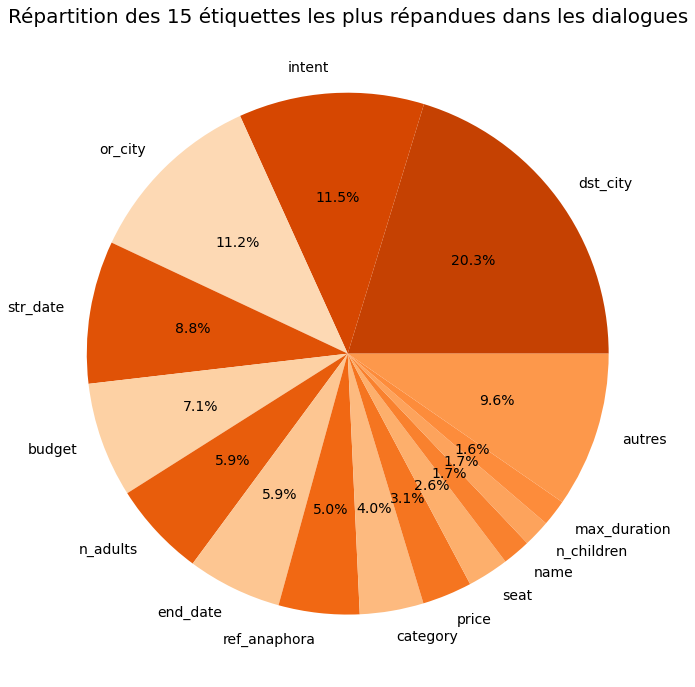

In [29]:
# Diagramme circulaire de la fréquence des labels
circle_degrade(
    df_15_labels, 'label', 'nb_valeurs',
    "Répartition des 15 étiquettes les plus répandues dans les dialogues",
    plt.cm.Oranges)

Nous voyons sur ce graphique que plus de la moitié des étiquettages concernent les villes de départ et d'arrivée, la date et l'intention.

Regardons maintenant la répartition des intentions et des entités qui nous intéressent.

### Les intentions

In [30]:
liste_intentions = ['book', 'None']

Les intentions dans notre base de données sont soit "intent", soit rien. Par conséquent, losqu'un dialogue n'a pas l'étiquettage "intent", cela signifie qu'il n'a pas l'intention "book". A partir du nombre de dialogues et du nombre d'étiquettes "intent", il est facile de trouver la répartition des intentions.

In [51]:
len(df[df["interlocuteur"] == "user"])

10407

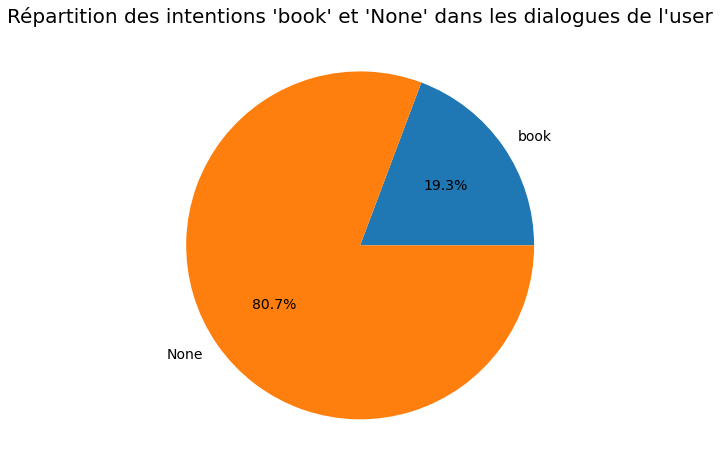

In [32]:
pie_intentions(df, labels, liste_intentions)
plt.ylabel("")
plt.title(
    "Répartition des intentions 'book' et 'None' dans les dialogues de l'user",
    pad=5,
    fontsize=20)
plt.show()

### Nos entités

In [33]:
liste_entites = ['dst_city', 'or_city', 'str_date', 'end_date', 'budget']

In [35]:
df_entites = df_entites(labels, liste_entites)

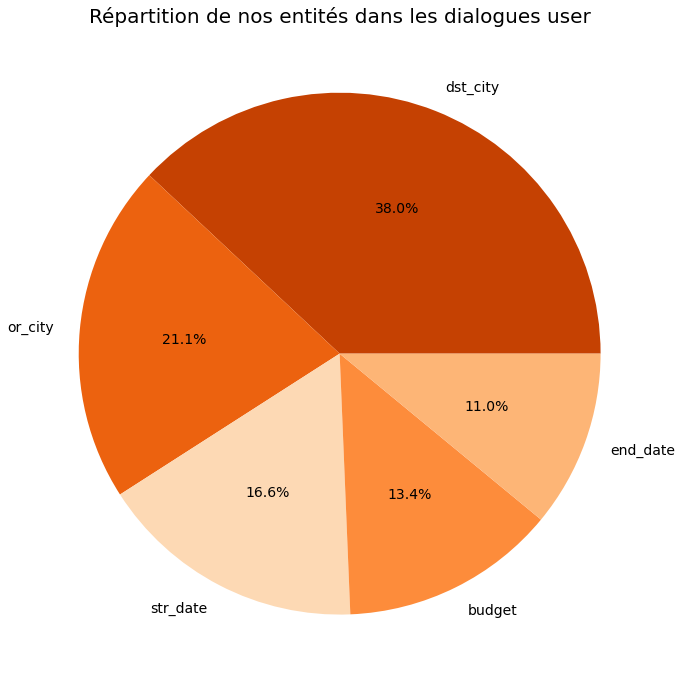

In [36]:
# Diagramme circulaire de la distribution des 5 labels qui nous intéressent
circle_degrade(df_entites, 'label', 'nb_valeurs',
               "Répartition de nos entités dans les dialogues user",
               plt.cm.Oranges)

# Préparation des données pour LUIS

Pour entraîner et tester notre modèle LUIS, nous avons besoin de deux choses :
    1 - identifier les intentions et entités qui nous intéressent et filtrer nos données en conséquence,
    2 - mettre les données au format accepté par LUIS.

## Préparation des données

### Exemple

Nous devons convertir nos textes avec nos turns en des exemples pour l'application. En effet, pour déterminer l’intention d’un énoncé et extraire des entités, l’application a besoin d’exemples d’énoncés. 

Les exemples doivent cibler une intention spécifique et unique, et doivent marquer toutes les entités personnalisées. 

Nous ajoutons des exemples d’énoncés en créant une liste d’objets ExampleLabelObject, un objet pour chaque exemple d’énoncé. Chaque exemple doit marquer toutes les entités avec un dictionnaire de paires nom/valeur de nom d’entité et de valeur d’entité. La valeur de l’entité doit être exactement telle qu’elle apparaît dans le texte de l’exemple d’énoncé.

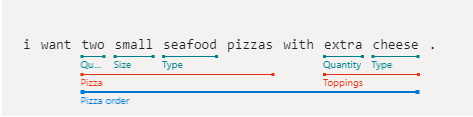

In [37]:
intentName = "OrderPizzaIntent"

Dans l'exemple ci-dessous, nous voyons la définition de chaque entité.
D'abord, nous voyons que l'intention est définie pour l'ensemble de la phrase : intentName": intentName = "OrderPizzaIntent"

Ensuite, nous voyons que chaque entité de la phrase a sa description :
L'entité "Pizza Order" commence à la lettre 7 et termine à la lettre 48.

A l'intérieur de cette entité se trouve les entités "pizza" et "topping" (respectivement de la lettre 7 à la lettre 30 et de la lettre 37 à la lettre 48). Ces entités ont aussi des sous-entités.

In [38]:
# Define labeled example
labeledExampleUtteranceWithMLEntity = {
    "text":
    "I want two small seafood pizzas with extra cheese.",
    "intentName":
    intentName,
    "entityLabels": [{
        "startCharIndex":
        7,
        "endCharIndex":
        48,
        "entityName":
        "Pizza order",
        "children": [{
            "startCharIndex":
            7,
            "endCharIndex":
            30,
            "entityName":
            "Pizza",
            "children": [{
                "startCharIndex": 7,
                "endCharIndex": 9,
                "entityName": "Quantity"
            }, {
                "startCharIndex": 11,
                "endCharIndex": 15,
                "entityName": "Size"
            }, {
                "startCharIndex": 17,
                "endCharIndex": 23,
                "entityName": "Type"
            }]
        }, {
            "startCharIndex":
            37,
            "endCharIndex":
            48,
            "entityName":
            "Toppings",
            "children": [{
                "startCharIndex": 37,
                "endCharIndex": 41,
                "entityName": "Quantity"
            }, {
                "startCharIndex": 43,
                "endCharIndex": 48,
                "entityName": "Type"
            }]
        }]
    }]
}

print("Labeled Example Utterance:", labeledExampleUtteranceWithMLEntity)

Labeled Example Utterance: {'text': 'I want two small seafood pizzas with extra cheese.', 'intentName': 'OrderPizzaIntent', 'entityLabels': [{'startCharIndex': 7, 'endCharIndex': 48, 'entityName': 'Pizza order', 'children': [{'startCharIndex': 7, 'endCharIndex': 30, 'entityName': 'Pizza', 'children': [{'startCharIndex': 7, 'endCharIndex': 9, 'entityName': 'Quantity'}, {'startCharIndex': 11, 'endCharIndex': 15, 'entityName': 'Size'}, {'startCharIndex': 17, 'endCharIndex': 23, 'entityName': 'Type'}]}, {'startCharIndex': 37, 'endCharIndex': 48, 'entityName': 'Toppings', 'children': [{'startCharIndex': 37, 'endCharIndex': 41, 'entityName': 'Quantity'}, {'startCharIndex': 43, 'endCharIndex': 48, 'entityName': 'Type'}]}]}]}


Dans notre cas, nous cherchons à déterminer si c'est une intention "book" ou "None" (l'intention None est obligatoire).
Nous cherchons aussi à localiser les entités :
        
- dst_city
- or_city
- str_date
- end_date
- budget 

### Préparation de nos données

In [39]:
liste_entites = ['dst_city', 'or_city', 'str_date', 'end_date', 'budget']

In [42]:
frames_luis = format_luis_frames(frames, "book", liste_entites)

Regardons à quoi ressemble une entrée pour notre modèle.

In [43]:
print(json.dumps(frames_luis[0], indent=2))

{
  "text": "I'd like to book a trip to Atlantis from Caprica on Saturday, August 13, 2016 for 8 adults. I have a tight budget of 1700.",
  "intent": "book",
  "entities": [
    {
      "entity": "dst_city",
      "startPos": 27,
      "endPos": 34,
      "children": []
    },
    {
      "entity": "or_city",
      "startPos": 41,
      "endPos": 47,
      "children": []
    },
    {
      "entity": "str_date",
      "startPos": 52,
      "endPos": 76,
      "children": []
    },
    {
      "entity": "budget",
      "startPos": 117,
      "endPos": 120,
      "children": []
    }
  ]
}


# Fonctions utiles

In [45]:
frames = load_and_transform(url_oc, nom_fichier, chemin_fichier)

Le téléchargement de vos données a commencé.
Le téléchargement des données est terminé.


In [46]:
frames[0]

{'user_id': 'U22HTHYNP',
 'turns': [{'text': "I'd like to book a trip to Atlantis from Caprica on Saturday, August 13, 2016 for 8 adults. I have a tight budget of 1700.",
   'labels': {'acts': [{'args': [{'val': 'book', 'key': 'intent'}],
      'name': 'inform'},
     {'args': [{'val': 'Atlantis', 'key': 'dst_city'},
       {'val': 'Caprica', 'key': 'or_city'},
       {'val': 'Saturday, August 13, 2016', 'key': 'str_date'},
       {'val': '8', 'key': 'n_adults'},
       {'val': '1700', 'key': 'budget'}],
      'name': 'inform'}],
    'acts_without_refs': [{'args': [{'val': 'book', 'key': 'intent'}],
      'name': 'inform'},
     {'args': [{'val': 'Atlantis', 'key': 'dst_city'},
       {'val': 'Caprica', 'key': 'or_city'},
       {'val': 'Saturday, August 13, 2016', 'key': 'str_date'},
       {'val': '8', 'key': 'n_adults'},
       {'val': '1700', 'key': 'budget'}],
      'name': 'inform'}],
    'active_frame': 1,
    'frames': [{'info': {'intent': [{'val': 'book', 'negated': False}],
 

In [49]:
frames_luis = format_luis_frames(frames, "book", liste_entites)

Regardons à quoi ressemble une entrée pour notre modèle.

In [50]:
print(json.dumps(frames_luis[0], indent=2))

{
  "text": "I'd like to book a trip to Atlantis from Caprica on Saturday, August 13, 2016 for 8 adults. I have a tight budget of 1700.",
  "intent": "book",
  "entities": [
    {
      "entity": "dst_city",
      "startPos": 27,
      "endPos": 34,
      "children": []
    },
    {
      "entity": "or_city",
      "startPos": 41,
      "endPos": 47,
      "children": []
    },
    {
      "entity": "str_date",
      "startPos": 52,
      "endPos": 76,
      "children": []
    },
    {
      "entity": "budget",
      "startPos": 117,
      "endPos": 120,
      "children": []
    }
  ]
}
